## Disease prediction from 15 thousand of biomarkers 

- This is simulated data
- Read in data from 3 resources, process json file to have patient profile in a pandas dataframe, then, merge all 3 sources of data into one dataframe
- Feature selection and feature engineering including data imputation, use **DictVectiverizer** to transform character columns into numeric features
- Model exploration to establish machine learning model
- Further feature selection based on **Feature Importance**
- Use pipeline to build multiple models to find the best performing classification model and establish the model with optimized hyperparameters

### 1. Pre-model Analysis: process and get insights of features and target.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important;}</style>"))

!jt -t grade3 -f  firacode  -fs 115  -of merriserif  -ofs 115 -tf firacode -tfs 120

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [3]:
pd.set_option('display.max_rows', 999)

### 1.1 Working on biomarker data

In [4]:
bio = pd.read_csv('./data/biomarkers.csv', low_memory=False,)
bio.head()

,biomarker_id,BM00000,BM00001,BM00002,BM00003,BM00004,BM00005,BM00006,BM00007,BM00008,...,BM15147,BM15148,BM15149,BM15150,BM15151,BM15152,BM15153,BM15154,BM15155,BM15156
0,100505de2,1,1,1,0,0,0,1,0,0,...,1,0,1,1,0,0,1,1.0,1,1
1,10075c5c2,1,1,1,0,0,0,1,0,1,...,1,0,0,0,0,0,1,NaN,1,1
2,10105cb22,1,1,1,0,0,0,1,0,1,...,1,0,0,0,0,0,1,NaN,1,1
3,101219d6e,1,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,1,1.0,1,1
4,10135ad45,1,0,1,0,1,0,1,0,1,...,1,0,1,0,0,0,1,1.0,1,1


In [5]:
bio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960 entries, 0 to 1959
Columns: 15158 entries, biomarker_id to BM15156
dtypes: float64(46), int64(15111), object(1)
memory usage: 226.7+ MB


In [6]:
# check how many columns have missing values and how many missings ewach
BioMiss = []
for i in bio.columns:
    if bio[i].isnull().sum() >1:
        BioMiss.append(i+':'+str(bio[i].isnull().sum()))
# BioMiss, len(BioMiss)        

In [7]:
# there are 46 columns each has 772 values missing (out of 1960 rows), so will drop these 46 columns

bio.dropna(axis='columns', inplace=True)   

In [8]:
# check how many columns have all 0 values and how many missings ewach
Zero = []
L = bio.columns.to_list()
L.remove('biomarker_id')
for i in L:
    if bio[i].sum() == 0:
        Zero.append(i)
# Zero, len(Zero) 

In [9]:
# there are 157 columns having all 0 values, so will drop these 157 columns

bio.drop(Zero, axis='columns', inplace=True)  

In [10]:
bio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960 entries, 0 to 1959
Columns: 14955 entries, biomarker_id to BM15156
dtypes: int64(14954), object(1)
memory usage: 223.6+ MB


### 1.2 Working on target data

In [11]:
tar = pd.read_csv('./data/targets.csv', low_memory=False,)
tar.head()

,patient_id,biomarker_id,target_label
0,1002df1d3,89c43bb4,0
1,1010441f,3ae31327,0
2,101eb6af1,1d8f7bab9,0
3,10204394e,129ee8c6c,0
4,1021d329b,1b44145bd,0


In [12]:
tar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 3 columns):
patient_id      1734 non-null object
biomarker_id    1734 non-null object
target_label    1734 non-null int64
dtypes: int64(1), object(2)
memory usage: 40.8+ KB


In [13]:
tar.target_label.value_counts()

0    1353
1     381
Name: target_label, dtype: int64

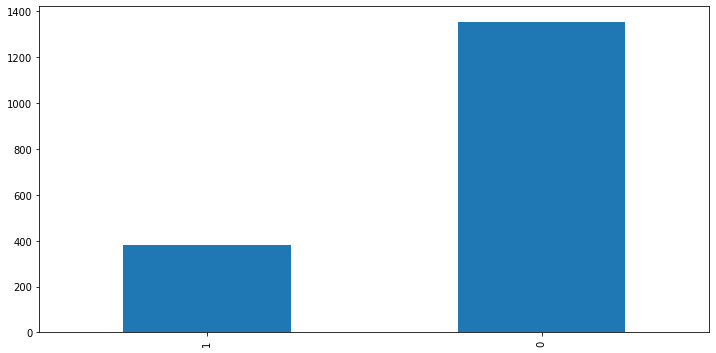

In [14]:
tar.target_label.value_counts(ascending=True).plot(kind='bar', figsize=(12,6))


### 1.3 Working on patient profiles data

In [15]:
import json

with open('./data/patient_profiles.json') as f:
  data = json.load(f)
# print(data)

In [16]:
# print(json.dumps(data, indent = 4, sort_keys=True))

In [17]:
data1= pd.DataFrame(data)
# data1.head()

In [18]:
data1['patient_profiles'][0][256]['patient_id']
# data1['patient_profiles'][0][0]['status']
# data1['patient_profiles'][0][0]['status']['smoking_status']

'ff4c5607'

In [19]:
def flatten_json(nested_json):
    """
        Flatten json object with nested keys into a single level.
        Args:
            nested_json: A nested json object.
        Returns:
            The flattened json object if successful, None otherwise.
    """
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '-')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '-')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(nested_json)
    return out

In [20]:
pp = pd.Series(flatten_json(data), name = "value" ).to_frame()

In [21]:
len(data)

7

In [22]:
pp.head(20)

,value
0-institution,Saint Penelope Medical Center
0-cohort_id,14562556998
0-patient_profiles-0-patient_id,102bb8fae
0-patient_profiles-0-demographics-gender,Female
0-patient_profiles-0-demographics-age,68
0-patient_profiles-0-status-disease_sub_type,A
0-patient_profiles-0-status-comorbidity_index,0
0-patient_profiles-0-status-cohort_qualifier,True
0-patient_profiles-0-status-smoking_status,never
0-patient_profiles-0-status-months_since_diagnosis,1


In [23]:
pp.reset_index(inplace=True)

In [24]:
pp.columns = ['name', 'value']

In [25]:
general = pp[~pp.name.str.contains('patient_profiles')]
general

,name,value
0,0-institution,Saint Penelope Medical Center
1,0-cohort_id,14562556998
2265,1-institution,"BioLab, Inc."
2266,1-cohort_id,14562556998
9230,2-institution,University Hospital System
9231,2-cohort_id,14562556998
12176,3-institution,Goodfellow Research Institute
12177,3-cohort_id,14562556998
12970,4-institution,Montague Hospital
12971,4-cohort_id,14562556998


In [26]:
patients = pp[pp.name.str.contains('patient_profiles')]

In [27]:
len(patients)

21436

In [28]:
patients

,name,value
2,0-patient_profiles-0-patient_id,102bb8fae
3,0-patient_profiles-0-demographics-gender,Female
4,0-patient_profiles-0-demographics-age,68
5,0-patient_profiles-0-status-disease_sub_type,A
6,0-patient_profiles-0-status-comorbidity_index,0
...,...,...
21445,6-patient_profiles-393-status-disease_sub_type,A
21446,6-patient_profiles-393-status-comorbidity_index,None
21447,6-patient_profiles-393-status-cohort_qualifier,True
21448,6-patient_profiles-393-status-smoking_status,current


In [29]:
patients['patient'] = patients.name.apply(lambda x: x.replace('patient_profiles-', ''))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
def pt(col):
    pt=[]
    for i in col:
        if i.isnumeric():
            pt.append(i)
    return ''.join(pt)
patients['pat'] = patients['patient'].apply(pt) 
#patients['pat']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [31]:
def sta(col):
    newcol = reversed(col)
    stat = []
    for i in newcol:
        if i.isalpha() or i == '_':
            stat.append(i)
        else:
            break
    return ''.join(reversed(stat))

patients['stat'] = patients['patient'].apply(sta)
#patients['stat']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [32]:
patients.tail()

,name,value,patient,pat,stat
21445,6-patient_profiles-393-status-disease_sub_type,A,6-393-status-disease_sub_type,6393,disease_sub_type
21446,6-patient_profiles-393-status-comorbidity_index,None,6-393-status-comorbidity_index,6393,comorbidity_index
21447,6-patient_profiles-393-status-cohort_qualifier,True,6-393-status-cohort_qualifier,6393,cohort_qualifier
21448,6-patient_profiles-393-status-smoking_status,current,6-393-status-smoking_status,6393,smoking_status
21449,6-patient_profiles-393-status-months_since_dia...,6,6-393-status-months_since_diagnosis,6393,months_since_diagnosis


In [33]:
table = pd.pivot_table(patients, index=['pat'], columns=['stat'],  values='value',
                    aggfunc= lambda x: x)
table.head()

stat,age,alcohol_usage,bmi_level,cohort_qualifier,comorbidity_index,days_since_diagnosis,disease_sub_type,exercise_frequency,gender,months_since_diagnosis,patient_id,race,smoking_status
pat,,,,,,,,,,,,,
00,68,NaN,NaN,True,0,NaN,A,NaN,Female,1,102bb8fae,NaN,never
01,66,NaN,NaN,True,NaN,NaN,A,NaN,Female,0,10e32947f,White,former
010,56,NaN,NaN,True,NaN,NaN,E,NaN,Male,0,11d09fadd,Asian,never
0100,65,NaN,NaN,True,NaN,NaN,A,NaN,Male,2,1f22eb6a0,NaN,never
0101,52,NaN,NaN,True,NaN,NaN,A,NaN,Female,0,1f4b96d81,Black or African American,current


In [34]:
table.patient_id.nunique()

2351

In [35]:
table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2351 entries, 00 to 699
Data columns (total 13 columns):
age                       2219 non-null object
alcohol_usage             378 non-null object
bmi_level                 266 non-null object
cohort_qualifier          2351 non-null object
comorbidity_index         485 non-null object
days_since_diagnosis      132 non-null object
disease_sub_type          2351 non-null object
exercise_frequency        378 non-null object
gender                    2351 non-null object
months_since_diagnosis    2219 non-null object
patient_id                2351 non-null object
race                      1758 non-null object
smoking_status            2219 non-null object
dtypes: object(13)
memory usage: 257.1+ KB


In [36]:
table.cohort_qualifier.value_counts()

True    2351
Name: cohort_qualifier, dtype: int64

In [37]:
# the following columns have too many NaN values, are dropped from the table
table.drop(['cohort_qualifier','alcohol_usage', 'bmi_level', 'comorbidity_index', 'days_since_diagnosis', 'exercise_frequency'], axis=1, inplace=True)
table.head(5)

stat,age,disease_sub_type,gender,months_since_diagnosis,patient_id,race,smoking_status
pat,,,,,,,
00,68,A,Female,1,102bb8fae,NaN,never
01,66,A,Female,0,10e32947f,White,former
010,56,E,Male,0,11d09fadd,Asian,never
0100,65,A,Male,2,1f22eb6a0,NaN,never
0101,52,A,Female,0,1f4b96d81,Black or African American,current


In [38]:
# impute NaN with mean for numeric, Unknown for character/categorical
table.loc[table['age'].isnull(),'age']=table.age.mean()
table.loc[table['disease_sub_type'].isnull(),'disease_sub_type']='Unknown'
table.loc[table['months_since_diagnosis'].isnull(),'months_since_diagnosis']=table.months_since_diagnosis.mean()
table.loc[table['race'].isnull(),'race']='Unknown'
table.race = table.race.apply(lambda x: x.lower() )
table.loc[table['smoking_status'].isnull(),'smoking_status']='Unknown'
table.smoking_status = table.smoking_status.apply(lambda x: x.lower() )


In [39]:
table.disease_sub_type.value_counts()

A    1562
B     349
C     216
F      82
D      72
E      70
Name: disease_sub_type, dtype: int64

In [40]:
table.race.value_counts()

white                                        1075
unknown                                       593
black or african american                     428
asian                                         221
native hawaiian or other pacific islander      19
american indian or alaska native               15
Name: race, dtype: int64

In [41]:
table.smoking_status.value_counts()

never      1025
current     588
former      484
unknown     254
Name: smoking_status, dtype: int64

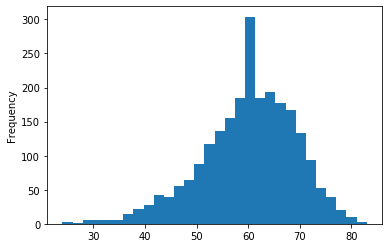

In [42]:
table.age.plot(kind='hist', bins=30)

In [43]:
# after imputation each column has the same length of rows and not missing
table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2351 entries, 00 to 699
Data columns (total 7 columns):
age                       2351 non-null object
disease_sub_type          2351 non-null object
gender                    2351 non-null object
months_since_diagnosis    2351 non-null object
patient_id                2351 non-null object
race                      2351 non-null object
smoking_status            2351 non-null object
dtypes: object(7)
memory usage: 146.9+ KB


In [44]:
bio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960 entries, 0 to 1959
Columns: 14955 entries, biomarker_id to BM15156
dtypes: int64(14954), object(1)
memory usage: 223.6+ MB


In [45]:
tar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 3 columns):
patient_id      1734 non-null object
biomarker_id    1734 non-null object
target_label    1734 non-null int64
dtypes: int64(1), object(2)
memory usage: 40.8+ KB


In [46]:
df = table.merge(tar, on='patient_id', how='inner')

In [47]:
df.head()

,age,disease_sub_type,gender,months_since_diagnosis,patient_id,race,smoking_status,biomarker_id,target_label
0,56,E,Male,0,11d09fadd,asian,never,ca9fd9fe,1
1,65,A,Male,2,1f22eb6a0,unknown,never,962019b9,0
2,52,A,Female,0,1f4b96d81,black or african american,current,e1603e02,0
3,57,D,Male,6,1f6b554e3,black or african american,current,18224ab9f,1
4,63,A,Female,4,1f748af57,black or african american,unknown,a2274b04,0


In [48]:
df = df.merge(bio, on='biomarker_id', how='inner')

In [49]:
#df

In [50]:
# delete 'patient_id','biomarker_id' from the dataframe for modeling
df.drop(['patient_id','biomarker_id'], axis =1, inplace=True)

In [51]:
df.head()

,age,disease_sub_type,gender,months_since_diagnosis,race,smoking_status,target_label,BM00000,BM00001,BM00002,...,BM15146,BM15147,BM15148,BM15149,BM15150,BM15151,BM15152,BM15153,BM15155,BM15156
0,56,E,Male,0,asian,never,1,1,1,1,...,1,0,0,1,0,1,0,1,1,1
1,65,A,Male,2,unknown,never,0,1,1,1,...,1,1,0,0,1,0,0,1,1,1
2,52,A,Female,0,black or african american,current,0,0,1,0,...,0,1,0,1,0,0,0,1,1,0
3,57,D,Male,6,black or african american,current,1,1,1,1,...,1,0,0,0,0,0,1,1,0,1
4,63,A,Female,4,black or african american,unknown,0,1,1,1,...,0,1,0,0,0,0,0,1,1,1


### 2. feature engineering

<font color="blue" font-size=18px>There are many ways for feature engineering, like manual dictionary, lambda function, OneHotEncoder, Countervecterizer, DictVectorizer
I choose DictVectorizer here for the speed and high quality for the feature engineering</font>

In [52]:
# data type conversion and put target out as independent data structure for modeling
df.age = df.age.astype(int)
df.months_since_diagnosis = df.months_since_diagnosis.astype(int)

target = df.target_label
df = df.drop('target_label', axis=1)

In [53]:
# turn df into dict: don’t need to extract the categorical features, convert the whole dataframe into a dict.
df_dict = df.to_dict(orient='records') # turn each row as key-value pairs
# show X_dict
df_dict

# DictVectorizer
from sklearn.feature_extraction import DictVectorizer
# instantiate a Dictvectorizer object for X
dv = DictVectorizer(sparse=False) 
# sparse = False makes the output is not a sparse matrix

# apply dv_X on X_dict
df_encoded = dv.fit_transform(df_dict)
# show X_encoded
df_encoded

array([[1., 1., 1., ..., 0., 1., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.]])

In [54]:
vocab = dv.vocabulary_
len(vocab)

14976

In [55]:
columns = [a[0] for a in sorted(dv.vocabulary_.items(), key=lambda x: x[-1])]
df_encoded = pd.DataFrame(df_encoded, columns=columns)
#df_encoded

In [56]:
print('target type: ', type(target), ";  " 'data frame type: ', type(df)  )

target type:  <class 'pandas.core.series.Series'> ;  data frame type:  <class 'pandas.core.frame.DataFrame'>


In [57]:
print('target length: ', len(target), ";  " 'data frame rows: ', len(df)  )

target length:  1734 ;  data frame rows:  1734


In [58]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(df_encoded, target,
                                   test_size=0.3, 
                                   random_state=2019)

X_train = X_train.reset_index(drop=True)
X_test = X_valid.reset_index(drop=True)

len(X_train), len(X_valid), len(y_train), len(y_valid)

(1213, 521, 1213, 521)

In [59]:
target.value_counts()

0    1353
1     381
Name: target_label, dtype: int64

In [60]:
y_train.value_counts()

0    949
1    264
Name: target_label, dtype: int64

In [61]:
y_valid.value_counts()

0    404
1    117
Name: target_label, dtype: int64

### <font color=blue>From above feature engineering, there are about 15,000 features and 1734 rows of observations. The target has about 80% of 0's and 20% of 1's. That means the label is imbalanced and the features much much more than observations. Let's try some modeling first to collect some information.</font>

### 3. Modeling: Model selection.

### 3.1 logistic regression model

In [62]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

steps = [ ('smt', SMOTE (random_state=2019)),
          ('rescale', MinMaxScaler()), 
          #('pca',     PCA(n_components=3) ),
          ('logr', LogisticRegression(C = 0.1, random_state = 2019, solver = 'sag')), ]
model = Pipeline(steps)
model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in

Pipeline(steps=[('smt', SMOTE(random_state=2019)), ('rescale', MinMaxScaler()),
                ('logr',
                 LogisticRegression(C=0.1, random_state=2019, solver='sag'))])

In [63]:
y_train_pred = model.predict(X_train)

y_valid_pred = model.predict(X_valid)

y_train_pred.shape, y_valid_pred.shape, #y_train_pred, y_valid_pred

((1213,), (521,))

In [64]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred,))

print(classification_report(y_valid, y_valid_pred,))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       949
           1       1.00      1.00      1.00       264

    accuracy                           1.00      1213
   macro avg       1.00      1.00      1.00      1213
weighted avg       1.00      1.00      1.00      1213

              precision    recall  f1-score   support

           0       0.77      0.99      0.87       404
           1       0.14      0.01      0.02       117

    accuracy                           0.77       521
   macro avg       0.46      0.50      0.44       521
weighted avg       0.63      0.77      0.68       521



In [65]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[949,   0],
       [  0, 264]], dtype=int64)

In [66]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_valid, y_valid_pred)
cm

array([[398,   6],
       [116,   1]], dtype=int64)

In [67]:
### ROC AUC
from sklearn.metrics import roc_auc_score
print('train roc_auc_scores:', roc_auc_score(y_train, y_train_pred, average='macro', ) )
print('valid roc_auc_scores: ', roc_auc_score(y_valid, y_valid_pred, average='macro', ) )

train roc_auc_scores: 1.0
valid roc_auc_scores:  0.4968477616992468


In [68]:
importance = model[2].coef_
len(importance[0])

14976

### 3.2 Random forest model

In [69]:
#from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

steps = [ ('smt', SMOTE (random_state=2019)),
          ('rescale', MinMaxScaler()),  
          ('pca',     PCA(n_components=3) ),
          ('rf', RandomForestClassifier(n_estimators = 100,  criterion = 'entropy', random_state = 2019)), ]
model = Pipeline(steps)
model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Pipeline(steps=[('smt', SMOTE(random_state=2019)), ('rescale', MinMaxScaler()),
                ('pca', PCA(n_components=3)),
                ('rf',
                 RandomForestClassifier(criterion='entropy',
                                        random_state=2019))])

In [70]:
y_train_pred = model.predict(X_train)

y_valid_pred = model.predict(X_valid)

y_train_pred.shape, y_valid_pred.shape#, y_train_pred, y_valid_pred

((1213,), (521,))

In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred,))

print(classification_report(y_valid, y_valid_pred,))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       949
           1       1.00      1.00      1.00       264

    accuracy                           1.00      1213
   macro avg       1.00      1.00      1.00      1213
weighted avg       1.00      1.00      1.00      1213

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       404
           1       0.24      0.17      0.20       117

    accuracy                           0.69       521
   macro avg       0.51      0.51      0.50       521
weighted avg       0.66      0.69      0.67       521



In [72]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[949,   0],
       [  0, 264]], dtype=int64)

In [73]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_valid, y_valid_pred)
cm

array([[341,  63],
       [ 97,  20]], dtype=int64)

In [74]:
### ROC AUC

from sklearn.metrics import roc_auc_score
print('train roc_auc_scores:', roc_auc_score(y_train, y_train_pred, average='macro', ) )
print('valid roc_auc_scores: ', roc_auc_score(y_valid, y_valid_pred, average='macro', ) )

train roc_auc_scores: 1.0
valid roc_auc_scores:  0.5074997884403825


### 3.3 SVM model: SVM is for the situation when feature number outsize observations

In [75]:
#from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

In [76]:
steps = [ ('smt', SMOTE (random_state=2019)),
          ('rescale', MinMaxScaler()), 
          ('SVM', SVC( random_state = 2019)), ]
model = Pipeline(steps)
model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Pipeline(steps=[('smt', SMOTE(random_state=2019)), ('rescale', MinMaxScaler()),
                ('SVM', SVC(random_state=2019))])

In [77]:
y_train_pred = model.predict(X_train)

y_valid_pred = model.predict(X_valid)

y_train_pred.shape, y_valid_pred.shape, #y_train_pred, y_valid_pred

((1213,), (521,))

In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred,))

print(classification_report(y_valid, y_valid_pred,))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       949
           1       1.00      0.95      0.97       264

    accuracy                           0.99      1213
   macro avg       0.99      0.98      0.98      1213
weighted avg       0.99      0.99      0.99      1213

              precision    recall  f1-score   support

           0       0.78      1.00      0.87       404
           1       0.00      0.00      0.00       117

    accuracy                           0.78       521
   macro avg       0.39      0.50      0.44       521
weighted avg       0.60      0.78      0.68       521



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[949,   0],
       [ 13, 251]], dtype=int64)

In [80]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_valid, y_valid_pred)
cm

array([[404,   0],
       [117,   0]], dtype=int64)

In [81]:
### ROC AUC
from sklearn.metrics import roc_auc_score
print('train roc_auc_scores:', roc_auc_score(y_train, y_train_pred, average='macro', ) )
print('valid roc_auc_scores: ', roc_auc_score(y_valid, y_valid_pred, average='macro', ) )

train roc_auc_scores: 0.9753787878787878
valid roc_auc_scores:  0.5


### <font color=blue>From above models, I see each model has test data ROC AUC equal or close to 0.5, which means the models are all overfitting, and does not provide any guidance for the classification. The reason may be because there are too many features combined with too few rows of data.</font>
### <font color=blue> Since I cannot add data for now, what I can do is to reduce features. </font>

### 4. Feature Selection and Pipeline for Model Analysis: Model performance, feature importance.

### 4.1 retrieve the feature importance information from logistic regression, and use it to select importannt features to rebuild the model

In [82]:
importance, len(importance[0])

(array([[ 0.00287843,  0.02284779,  0.03435197, ...,  0.02117537,
         -0.08210021,  0.00743898]]), 14976)

In [83]:
len(importance[0].tolist())

14976

In [84]:
# the following are the first 10 and last 10 columns in X_train originally:
Lst = X_train.columns.to_list()
Lst[:10], Lst[-10:]

(['BM00000',
  'BM00001',
  'BM00002',
  'BM00003',
  'BM00004',
  'BM00005',
  'BM00006',
  'BM00007',
  'BM00008',
  'BM00009'],
 ['race=american indian or alaska native',
  'race=asian',
  'race=black or african american',
  'race=native hawaiian or other pacific islander',
  'race=unknown',
  'race=white',
  'smoking_status=current',
  'smoking_status=former',
  'smoking_status=never',
  'smoking_status=unknown'])

In [85]:
# the following are 10 most importanct columns positively (in Lst1) and 10 most important columns negatively (in Lst2) according to feature importance
imp,names_ = zip(*sorted(zip(importance[0],Lst)))
imp1 = imp[:10]
imp2 = imp[-10:]
Lst1 = names_[-10:]
Lst2 = names_[:10]
L = list(Lst1 + Lst2)
print('10 most important columns in positive way: ', Lst1, '\n10 most important columns in negative way: ', Lst2)

10 most important columns in positive way:  ('BM07629', 'BM13361', 'BM05369', 'BM12965', 'BM03942', 'BM09011', 'BM12689', 'BM02749', 'BM07862', 'BM10516') 
10 most important columns in negative way:  ('BM11831', 'BM08470', 'BM12940', 'BM13553', 'BM04160', 'BM12667', 'BM09770', 'BM04402', 'BM14192', 'BM10757')


In [86]:
from matplotlib import pyplot as plt
from sklearn import svm

In [87]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    imp1 = imp[:10]
    imp2 = imp[-10:]
    Lst1 = names[-10:]
    Lst2 = names[:10]
    L = Lst1 + Lst2

    
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.barh(range(len(Lst2)), imp2, align='center')
    plt.yticks(range(len(Lst2)), Lst2)
    plt.title('10 most important features with positive values')

    plt.subplot(1,2, 2)
    plt.barh(range(len(Lst1)), imp1, align='center')
    plt.yticks(range(len(Lst1)), Lst1)
    plt.title('10 most important features with negative values')


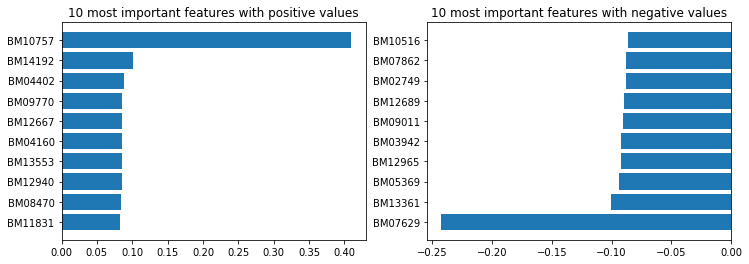

In [88]:
f_importances(importance[0], Lst)

In [89]:
# rebuild the X_train and X_valid with reduced features

In [90]:
X_train1 = X_train[L]
X_valid1 = X_valid[L]


### 4.2 SVM model: for feature reduced X_train and X_valid

In [91]:
#from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

steps = [('smt', SMOTE (random_state=2019)),
         ('rescale', MinMaxScaler()), 
         ('SVM', SVC( random_state = 2019)), ]
model = Pipeline(steps)
model.fit(X_train1, y_train)

y_train_pred = model.predict(X_train1)

y_valid_pred = model.predict(X_valid1)


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred,))

print(classification_report(y_valid, y_valid_pred,))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_train_pred)
cm

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       949
           1       0.86      0.90      0.88       264

    accuracy                           0.95      1213
   macro avg       0.92      0.93      0.92      1213
weighted avg       0.95      0.95      0.95      1213

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       404
           1       0.63      0.59      0.61       117

    accuracy                           0.83       521
   macro avg       0.76      0.75      0.75       521
weighted avg       0.83      0.83      0.83       521



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


array([[911,  38],
       [ 27, 237]], dtype=int64)

In [92]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_valid, y_valid_pred)
cm

array([[364,  40],
       [ 48,  69]], dtype=int64)

In [93]:
### ROC AUC
from sklearn.metrics import roc_auc_score
print('train roc_auc_scores:', roc_auc_score(y_train, y_train_pred, average='macro', ) )
print('valid roc_auc_scores: ', roc_auc_score(y_valid, y_valid_pred, average='macro', ) )

train roc_auc_scores: 0.9288425615480411
valid roc_auc_scores:  0.7453668443767455


### <font color=blue>Note: I have tried not only above 20 features, but also first 5 important features, first 20 important features,  first 5 important features plus first 5 important negative features, first 20 important features plus first 20 negative features, respectively. After comparing the ROC AUC, I found that the features selected in above model has the best performance. So, next I will use these 20 features in train and valid data, use multiple models with hyperparameter tuning to see which one has the best performance. </font> 

### 4.3 Pipeline to buid multiple models, and Grid Searches to compare the performance of different models

In [94]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
#import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [95]:
# Construct some pipelines
pipe_lr = Pipeline([ ('smt', SMOTE (random_state=2019)),
                     ('rescale', MinMaxScaler()), 
                     ('clf', LogisticRegression(random_state=2019))])

pipe_lr_pca = Pipeline([('smt', SMOTE (random_state=2019)),
                        ('rescale', MinMaxScaler()), 
                        ('pca', PCA(n_components=2)),
                        ('clf', LogisticRegression(random_state=2019))])

pipe_rf = Pipeline([('smt', SMOTE (random_state=2019)),
                    ('rescale', MinMaxScaler()), 
                    ('clf', RandomForestClassifier(random_state=2019))])

pipe_rf_pca = Pipeline([('smt', SMOTE (random_state=2019)),
                        ('rescale', MinMaxScaler()), 
                        ('pca', PCA(n_components=2)),
                        ('clf', RandomForestClassifier(random_state=2019))])

pipe_svm = Pipeline([('smt', SMOTE (random_state=2019)),
                     ('rescale', MinMaxScaler()), 
                     ('clf', svm.SVC(random_state=2019))])

pipe_svm_pca = Pipeline([('smt', SMOTE (random_state=2019)),
                         ('rescale', MinMaxScaler()), 
                         ('pca', PCA(n_components=2)),
                         ('clf', svm.SVC(random_state=2019))])

# Set grid search params
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [10, 1.0, 0.1]

grid_params_lr = [{ 'clf__penalty': ['l1', 'l2'],
                    'clf__C': param_range_fl,
                    'clf__solver': ['liblinear']}] 

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
                   'clf__min_samples_leaf': param_range,
                   'clf__max_depth': param_range,
                   'clf__min_samples_split': param_range[1:]}]

grid_params_svm = [{'clf__kernel': ['linear', 'rbf'], 
                    'clf__C': param_range}]

# Construct grid searches
jobs = -1

gs_lr = GridSearchCV(estimator=pipe_lr,
                param_grid=grid_params_lr,
                scoring='roc_auc',
                cv=5) 

gs_lr_pca = GridSearchCV(estimator=pipe_lr_pca,
                param_grid=grid_params_lr,
                scoring='roc_auc',
                cv=5)

gs_rf = GridSearchCV(estimator=pipe_rf,
                param_grid=grid_params_rf,
                scoring='roc_auc',
                cv=5, 
                n_jobs=jobs)

gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
                param_grid=grid_params_rf,
                scoring='roc_auc',
                cv=5, 
                n_jobs=jobs)

gs_svm = GridSearchCV(estimator=pipe_svm,
                param_grid=grid_params_svm,
                scoring='roc_auc',
                cv=5,
                n_jobs=jobs)

gs_svm_pca = GridSearchCV(estimator=pipe_svm_pca,
                param_grid=grid_params_svm,
                scoring='roc_auc',
                cv=5,
                n_jobs=jobs)

# List of pipelines for ease of iteration
grids = [gs_lr, gs_lr_pca, gs_rf, gs_rf_pca, gs_svm, gs_svm_pca]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression', 1: 'Logistic Regression w/PCA', 
            2: 'Random Forest', 3: 'Random Forest w/PCA', 
            4: 'Support Vector Machine', 5: 'Support Vector Machine w/PCA'}


# Fit the grid search objects
print('Performing model optimizations...')
best_auc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(X_train1, y_train)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data roc auc
    print('Best training roc auc: %.3f' % gs.best_score_)
    # Predict on valid data with best params
    y_pred = gs.predict(X_valid1)
    # Test data auc of model with best params
    print('Valid set auc score for best params: %.3f ' % roc_auc_score(y_valid, y_pred))
    # Track best (highest test roc auc) model
    if roc_auc_score(y_valid, y_pred) > best_auc:
        best_auc = roc_auc_score(y_valid, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set roc_auc: %s' % grid_dict[best_clf])

Performing model optimizations...

Estimator: Logistic Regression


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, cate

Best params: {'clf__C': 10, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training roc auc: 0.919
Valid set auc score for best params: 0.757 

Estimator: Logistic Regression w/PCA


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, cate

Best params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training roc auc: 0.841
Valid set auc score for best params: 0.643 

Estimator: Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best params: {'clf__criterion': 'gini', 'clf__max_depth': 9, 'clf__min_samples_leaf': 7, 'clf__min_samples_split': 2}
Best training roc auc: 0.915
Valid set auc score for best params: 0.743 

Estimator: Random Forest w/PCA


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 4, 'clf__min_samples_leaf': 7, 'clf__min_samples_split': 4}
Best training roc auc: 0.843
Valid set auc score for best params: 0.617 

Estimator: Support Vector Machine


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best params: {'clf__C': 3, 'clf__kernel': 'linear'}
Best training roc auc: 0.918
Valid set auc score for best params: 0.747 

Estimator: Support Vector Machine w/PCA
Best params: {'clf__C': 4, 'clf__kernel': 'linear'}
Best training roc auc: 0.840
Valid set auc score for best params: 0.626 

Classifier with best test set roc_auc: Logistic Regression


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### <font color=blue> I compared 6 models: Logistic, Logistic + PCA, Random Forest, Random Forest + PCA, SVM, SVM + PCA. From the output, you can see that Logistic Regression is the best model with ROC AUC of validation data 0.757 </font>

### <font color=blue> Below is the final model: Logistic regression with hyperparameters setting obtained from above GridSearch model. Training set has a ROC AUC 0.847, and test data ROC AUC is 0.757. The test data has a precision of 0.53, recall 0.69, f1-score is 0.6 </font>

In [96]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

steps = [ ('smt', SMOTE (random_state=2019)),
          ('rescale', MinMaxScaler()), 
          ('logr', LogisticRegression(C = 10, random_state = 2019, penalty='l1', solver = 'liblinear')), ]
model = Pipeline(steps)
model.fit(X_train1, y_train)

y_train_pred = model.predict(X_train1)

y_valid_pred = model.predict(X_valid1)

y_train_pred.shape, y_valid_pred.shape, X_train1.shape, X_valid1.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((1213,), (521,), (1213, 20), (521, 20))

In [97]:
# from sklearn.metrics import accuracy_score

# print ("y_train Accuracy Rate, which is calculated by accuracy_score() is: %.3f"%accuracy_score(y_train, y_train_pred) )
# print ("y_test Accuracy Rate, which is calculated by accuracy_score() is: %.3f"%accuracy_score(y_valid, y_valid_pred) )

from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred,))

print(classification_report(y_valid, y_valid_pred,))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_train_pred)
cm

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       949
           1       0.65      0.82      0.72       264

    accuracy                           0.86      1213
   macro avg       0.80      0.85      0.82      1213
weighted avg       0.88      0.86      0.87      1213

              precision    recall  f1-score   support

           0       0.90      0.82      0.86       404
           1       0.53      0.69      0.60       117

    accuracy                           0.79       521
   macro avg       0.72      0.76      0.73       521
weighted avg       0.82      0.79      0.80       521



array([[832, 117],
       [ 48, 216]], dtype=int64)

In [98]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_valid, y_valid_pred)
cm

array([[332,  72],
       [ 36,  81]], dtype=int64)

In [99]:
### ROC AUC
from sklearn.metrics import roc_auc_score
print('train roc_auc_scores:', roc_auc_score(y_train, y_train_pred, average='macro', ) )
print('valid roc_auc_scores: ', roc_auc_score(y_valid, y_valid_pred, average='macro', ) )

train roc_auc_scores: 0.8474470734744708
valid roc_auc_scores:  0.7570449352627571


### 5. Post-model Analysis: Model performance, actionable suggestions to business.

### 5.1 This is a preliminary analysis, more work need to be done to understand the data, to understand the patient demographic data and disease conditions and how are they linked to the biomarker performance.

### 5.2 More data are needed since this analysis has 10s of thousands of features, but there are only thousands of observations.